<a href="https://colab.research.google.com/github/rkh4m/CS4824_Capstone_Project/blob/main/Movie_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**
**Problem Statement**: The IMDb Movie Reviews Dataset for Sentiment (positive or negative) analysis is infamous as a prime example of Machine Learning for Natural Language Processing (NLP). Written movie reviews are used to train a model to detect and predict the sentiment a user intended to convey throughout their review, which presents several challenges. Current models experience performance degradation when long-form reviews (over 200 words) are processed, as the model loses track of the context, “focus” on the main idea of the review, and the semantic meaning of a large review.
****

**Notebook Overview**: This notebook contains various models of the **BERT** family, which are pre-trained models known for their ability to recognize sentiment through text. We will compare three commonly used BERT models using the same configuration: **BERT-base-uncased**, **BERT-base-large**, and **RoBERTa**, then continue to improve the best preforming model through parameter fine-tuning.
****

### **Section Breakdown**

The notebook is broken down into the following sections:

1. **EDA and Data Setup**
2. **BERT Family Evaluation**
3. **Fine Tuning**
4. **Parameter Tuning**
5. **Best Bert Model Tunning**
6. **Project Conclusion**

## **Section 1: EDA and Data Setup**
This section inspects the class balance, text lengths, and missing values in the movie review training split, also this primes the data for model use.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

DATA_PATH = "Train.csv"
train_df = pd.read_csv(DATA_PATH, encoding="utf-8-sig")

print(f"Train shape: {train_df.shape}")
train_df.head()

Train shape: (40000, 2)


,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


The training data has **40,000** entries with text and label per entry.

**Label Meaning:**

**0** - Negative Review

**1** - Positive Review

### **1.1: Schema and Missing Values**
Understand the column types and presence of nulls before modeling.

In [2]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [3]:
missing_summary = train_df.isnull().mean().mul(100).round(2)
missing_summary.to_frame(name="percent_missing")

,percent_missing
text,0.0
label,0.0


Based on these results, the dataset is **clean** (no null text or label values).

### **1.2: Class Distribution**
Check whether the dataset is balanced across sentiment labels.

In [4]:
label_counts = train_df['label'].value_counts().sort_index()
label_counts

,count
label,
0,20019
1,19981


/tmp/ipython-input-2581298822.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


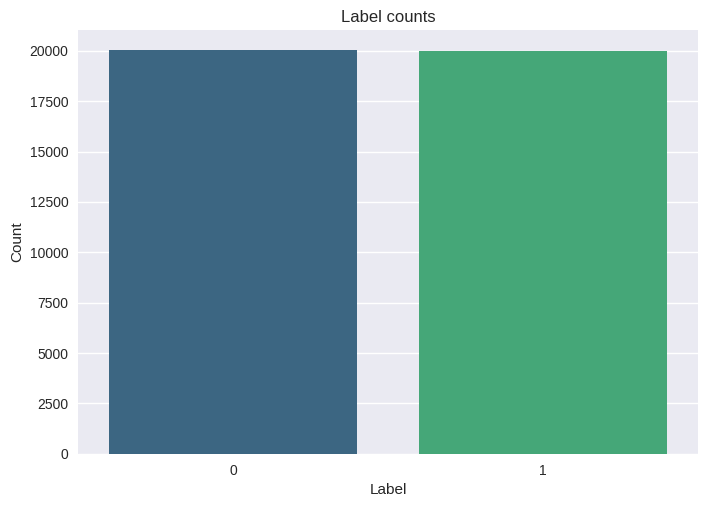

In [5]:
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.title("Label counts")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

This dataset is **balanced** between positive and negative reviews.

### **1.3: Review Length Analysis**
Assess how long the reviews are to guide tokenization choices.

In [6]:
train_df['char_len'] = train_df['text'].str.len()
train_df['word_len'] = train_df['text'].str.split().str.len()

length_summary = train_df[['char_len', 'word_len']].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])
length_summary

,char_len,word_len
count,40000.000000,40000.000000
mean,1310.293250,231.339250
std,988.358599,171.194123
min,32.000000,4.000000
10%,501.000000,90.000000
25%,698.000000,126.000000
50%,973.000000,173.000000
75%,1596.000000,282.000000
90%,2583.100000,452.000000
max,13704.000000,2470.000000


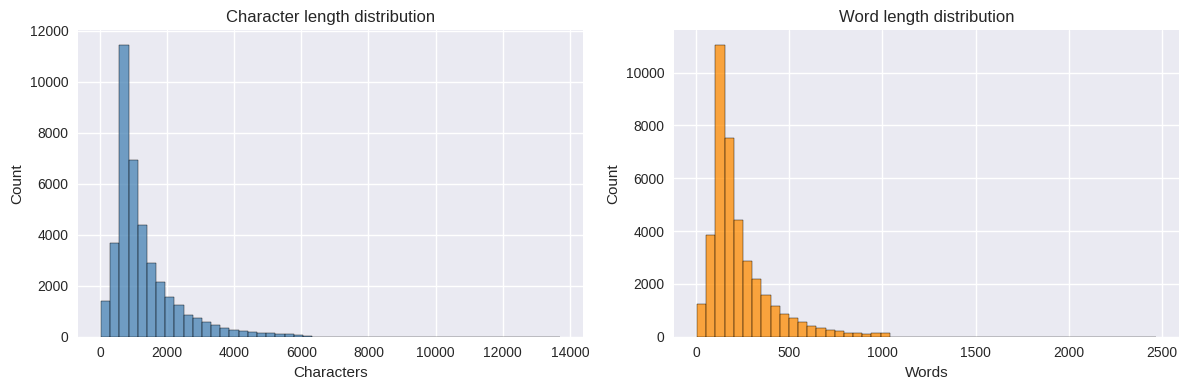

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(train_df['char_len'], bins=50, ax=axes[0], color="steelblue")
axes[0].set_title("Character length distribution")
axes[0].set_xlabel("Characters")

sns.histplot(train_df['word_len'], bins=50, ax=axes[1], color="darkorange")
axes[1].set_title("Word length distribution")
axes[1].set_xlabel("Words")

plt.tight_layout()
plt.show()

While the **average** length of a review is about 231 words, the **range** of our data large, so evaluating which token length is the most effective is crucial when fine-tuning.

### **1.4: Length by Label**
Compare how review length differs across sentiment classes.

In [8]:
length_by_label = train_df.groupby('label')[['char_len', 'word_len']].agg(['mean', 'median', 'max']).round(1)
length_by_label

char_len               word_len             
          mean median    max     mean median   max
label                                             
0       1292.5  973.0   8969    229.2  174.0  1522
1       1328.1  972.0  13704    233.5  173.0  2470

Both labels have similar **mean** char and word lenghts, but the max char and word lengths may provide some challenges when tokenizing the review.

## **Section 2: BERT Family Evaluation**
We will be comparing the BERT-base-uncased, BERT-large-uncased, and RoBERTa models.

### **2.1: Environment Setup and Configuration**
Splitting our dataset into 3 sections: test, train and validate.

In [9]:
import torch
print(torch.cuda.is_available())

True


In [10]:
from datasets import load_dataset
import re

# Load our dataset
data_files = {"train": "Train.csv", "test": "Test.csv", "valid": "Valid.csv"}
dataset = load_dataset("csv", data_files=data_files)

print(dataset["test"][0])

{'text': 'I always wrote this series off as being a complete stink-fest because Jim Belushi was involved in it, and heavily. But then one day a tragic happenstance occurred. After a White Sox game ended I realized that the remote was all the way on the other side of the room somehow. Now I could have just gotten up and walked across the room to get the remote, or even to the TV to turn the channel. But then why not just get up and walk across the country to watch TV in another state? "Nuts to that", I said. So I decided to just hang tight on the couch and take whatever Fate had in store for me. What Fate had in store was an episode of this show, an episode about which I remember very little except that I had once again made a very broad, general sweeping blanket judgment based on zero objective or experiential evidence with nothing whatsoever to back my opinions up with, and once again I was completely right! This show is a total crud-pie! Belushi has all the comedic delivery of a hair

The label value is already numeric (0 or 1), so no need to reprocess and change that.

In [11]:
from transformers import AutoTokenizer

# bert tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=256)

# apply the tokenizer to the dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# inspect tokenized samples
print(tokenized_datasets["test"][0])



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

{'text': 'I always wrote this series off as being a complete stink-fest because Jim Belushi was involved in it, and heavily. But then one day a tragic happenstance occurred. After a White Sox game ended I realized that the remote was all the way on the other side of the room somehow. Now I could have just gotten up and walked across the room to get the remote, or even to the TV to turn the channel. But then why not just get up and walk across the country to watch TV in another state? "Nuts to that", I said. So I decided to just hang tight on the couch and take whatever Fate had in store for me. What Fate had in store was an episode of this show, an episode about which I remember very little except that I had once again made a very broad, general sweeping blanket judgment based on zero objective or experiential evidence with nothing whatsoever to back my opinions up with, and once again I was completely right! This show is a total crud-pie! Belushi has all the comedic delivery of a hair

The max_length for token truncation is set to 256 to capture most of the values. Since the mean word length of a review is 231, we attempt to capture them with 256 tokens.

### **2.2: Evaluation of Pre-Trained Models**


In this section, we define our custom metrics function which will capture the evaluation accuracy, precision, recall, and f1 score of the pre-trained models. For tokenization, we repeat the process using the BERT tokeinzer and 256 tokens each time.

In [12]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd
import numpy as np
import os

os.environ["WANDB_DISABLED"] = "true"

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted"),
    }

# models to evaluate for baseline
model_names = [
    "bert-base-uncased",
    "bert-large-uncased",
    "FacebookAI/roberta-base"
]

# Change BASE_SAVE_DIR to a temporary local path
BASE_SAVE_DIR = "/tmp/nlp_models/multi_model_eval"
os.makedirs(BASE_SAVE_DIR, exist_ok=True)

# set training (eval) arguments
eval_args = TrainingArguments(
    output_dir=BASE_SAVE_DIR,
    per_device_eval_batch_size=16,
    logging_dir=os.path.join(BASE_SAVE_DIR, "logs"),
    report_to="none"
)

all_results = []

# evaluate all models
for model_name in model_names:
    print(f"\nEvaluating model: {model_name}")

    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # Set up Trainer
    trainer = Trainer(
        model=model,
        args=eval_args,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    # Evaluate on test and validation splits
    test_results = trainer.evaluate(tokenized_datasets["test"])
    valid_results = trainer.evaluate(tokenized_datasets["valid"])

    # Save results to a dataframe
    all_results.append({"model": model_name, "split": "test", **test_results})
    all_results.append({"model": model_name, "split": "validation", **valid_results})

results_df = pd.DataFrame(all_results)
results_path = os.path.join(BASE_SAVE_DIR, "multi_model_results.csv")
results_df.to_csv(results_path, index=False)

print(f"\nEvaluation complete for all models.")
print(f"Results saved to:\n{results_path}")
display(results_df)



Evaluating model: bert-base-uncased


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1210999888.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Evaluating model: bert-large-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1210999888.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Evaluating model: FacebookAI/roberta-base


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1210999888.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Evaluation complete for all models.
Results saved to:
/tmp/nlp_models/multi_model_eval/multi_model_results.csv


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,model,split,eval_loss,eval_model_preparation_time,eval_accuracy,eval_f1,eval_precision,eval_recall,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,bert-base-uncased,test,0.710018,0.0026,0.5008,0.336911,0.673373,0.5008,19.1019,261.753,16.386
1,bert-base-uncased,validation,0.712029,0.0026,0.4976,0.332175,0.561555,0.4976,18.6052,268.742,16.823
2,bert-large-uncased,test,1.370672,0.0050,0.4990,0.332223,0.249001,0.4990,53.1399,94.091,5.890
3,bert-large-uncased,validation,1.374067,0.0050,0.4972,0.330227,0.247208,0.4972,53.2822,93.840,5.874
4,FacebookAI/roberta-base,test,0.694687,0.0027,0.5010,0.334445,0.251001,0.5010,18.4831,270.518,16.934
5,FacebookAI/roberta-base,validation,0.694566,0.0027,0.5028,0.336449,0.252808,0.5028,18.6396,268.247,16.792


From initial testing, all models seem to be inaccurate when evaluated without fine-tuning, with RoBERTa having the worst performance followed by bert-large.

### **2.3: Visual Comparison of Pre-trained Models**

Next, we generate plots with the data from evaluating the pre-trained models to be able to observe the differences graphically.

/tmp/ipython-input-3912856268.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=25, ha="right")
/tmp/ipython-input-3912856268.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-3912856268.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=25, ha="right")


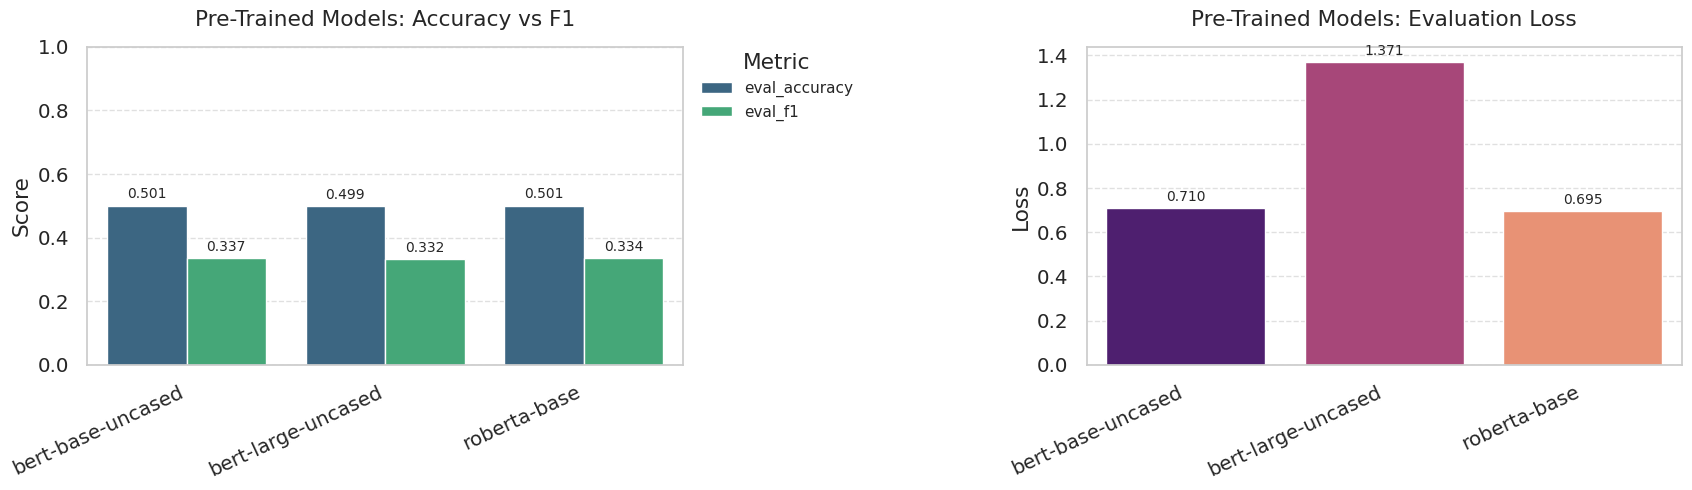

In [13]:
# Define RESULTS_PATH to load from the temporary location where it was saved
RESULTS_PATH = "/tmp/nlp_models/multi_model_eval/multi_model_results.csv"

# Load results
baseline_df = pd.read_csv(RESULTS_PATH)

# Clean model names (remove prefixes like 'FacebookAI/')
baseline_df["model_clean"] = baseline_df["model"].str.replace("FacebookAI/", "", regex=False)

# Keep only test split for main comparison
baseline_df = baseline_df[baseline_df["split"] == "test"].copy()

sns.set(style="whitegrid", font_scale=1.3)

melted = baseline_df.melt(
    id_vars="model_clean",
    value_vars=["eval_accuracy", "eval_f1"],
    var_name="Metric",
    value_name="Score"
)

fig, axes = plt.subplots(1, 2, figsize=(18,6))

# -----------------------------
# Left: Accuracy vs F1
# -----------------------------
sns.barplot(
    data=melted,
    x="model_clean", y="Score", hue="Metric",
    palette="viridis", ax=axes[0]
)

for container in axes[0].containers:
    axes[0].bar_label(container, fmt="%.3f", fontsize=10, padding=3)

axes[0].set_title("Pre-Trained Models: Accuracy vs F1", pad=15)
axes[0].set_xlabel("")
axes[0].set_ylabel("Score")
axes[0].set_ylim(0.0, 1.0)
axes[0].grid(axis="y", linestyle="--", alpha=0.6)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=25, ha="right")

axes[0].legend(
    title="Metric",
    loc="upper left",
    bbox_to_anchor=(1.02, 1),
    borderaxespad=0,
    fontsize=11
)

# -----------------------------
# Right: Evaluation Loss
# -----------------------------
sns.barplot(
    data=baseline_df,
    x="model_clean", y="eval_loss",
    palette="magma", ax=axes[1]
)

for container in axes[1].containers:
    axes[1].bar_label(container, fmt="%.3f", fontsize=10, padding=3)

axes[1].set_title("Pre-Trained Models: Evaluation Loss", pad=15)
axes[1].set_xlabel("")
axes[1].set_ylabel("Loss")
axes[1].grid(axis="y", linestyle="--", alpha=0.6)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=25, ha="right")

plt.tight_layout(pad=3.0, w_pad=7.0)
plt.show()


Here, we specifically focus on F1 score for comparison via a bar chart. F1 score is a crucial metric we use to evaluate the accuracy of a classification model.

/tmp/ipython-input-1504635415.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


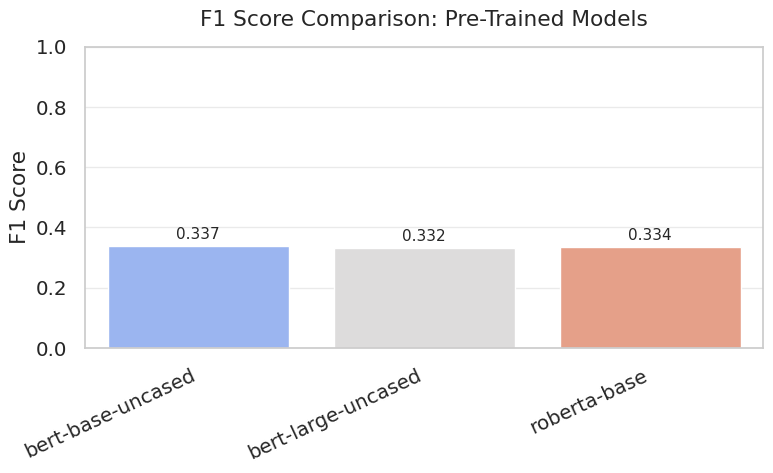

In [14]:
plt.figure(figsize=(8,5))
ax = sns.barplot(
    data=baseline_df,
    x="model_clean", y="eval_f1",
    palette="coolwarm"
)

# --- Add value annotations on top of each bar ---
for container in ax.containers:
    ax.bar_label(container, fmt="%.3f", fontsize=11, padding=3)

plt.title("F1 Score Comparison: Pre-Trained Models", pad=15)
plt.xlabel("")
plt.ylabel("F1 Score")
plt.ylim(0, 1.0)
plt.grid(axis="y", alpha=0.4)
plt.xticks(rotation=25, ha="right")
plt.tight_layout()
plt.show()

UndefinedMetricWarning: From our research, this issue seems to stem from the fact that the given model never predicted one of the classes, likely due to not fine-tuning yet. The model also likely predicted the majority class.

##**Section 3: Fine-Tuning**

In this section, we perform fine-tuning on each of the three models, using the same training arguments and parameters. These parameters were specifically taken from the original BERT paper. One key difference is the use of fp16=True in order to enable faster training times on Google Colab.

### **3.1: Fine-Tuning Execution**


In [15]:
# Fine tuning step
BASE_SAVE_DIR = "/tmp/nlp_models/fine_tuned_models"
os.makedirs(BASE_SAVE_DIR, exist_ok=True)
os.environ["WANDB_DISABLED"] = "true"

fine_tuned_results = []

for model_name in model_names:
    print(f"\nFine-tuning model: {model_name}")

    SAVE_DIR = os.path.join(BASE_SAVE_DIR, model_name.replace("/", "_"))
    os.makedirs(SAVE_DIR, exist_ok=True)

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # Training configuration
    training_args = TrainingArguments(
        output_dir=SAVE_DIR,
        do_train=True,
        do_eval=True,
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=3,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        fp16=True,
        logging_dir=os.path.join(SAVE_DIR, "logs"),
        logging_strategy="epoch",
        report_to="none",
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["valid"],
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    # train
    trainer.train()

    # evaluate on test - final evaluation to compare to baseline
    test_results = trainer.evaluate(tokenized_datasets["test"])
    valid_results = trainer.evaluate(tokenized_datasets["valid"])

    # save the metrics and models
    fine_tuned_results.append({"model": model_name, "split": "test", **test_results})
    fine_tuned_results.append({"model": model_name, "split": "validation", **valid_results})

    trainer.save_model(SAVE_DIR)
    tokenizer.save_pretrained(SAVE_DIR)

    print(f"Fine-tuned model saved to {SAVE_DIR}")

fine_tuned_df = pd.DataFrame(fine_tuned_results)
fine_tuned_path = os.path.join(BASE_SAVE_DIR, "fine_tuned_results.csv")
fine_tuned_df.to_csv(fine_tuned_path, index=False)

print(f"\nAll fine-tuned model results saved to:\n{fine_tuned_path}")
display(fine_tuned_df)



Fine-tuning model: bert-base-uncased


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3858251725.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.250900,0.193906,0.927400,0.927388,0.927570,0.927400
2,0.139400,0.221750,0.926800,0.926784,0.927053,0.926800
3,0.075900,0.279443,0.929400,0.929378,0.929775,0.929400


Fine-tuned model saved to /tmp/nlp_models/fine_tuned_models/bert-base-uncased

Fine-tuning model: bert-large-uncased


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3858251725.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.244800,0.180331,0.934400,0.934397,0.934437,0.934400
2,0.115800,0.233615,0.931800,0.931757,0.932667,0.931800
3,0.054400,0.272342,0.936400,0.936396,0.936444,0.936400


Fine-tuned model saved to /tmp/nlp_models/fine_tuned_models/bert-large-uncased

Fine-tuning model: FacebookAI/roberta-base


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3858251725.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.530300,0.483803,0.804400,0.802834,0.815253,0.804400
2,0.360100,0.399695,0.838200,0.837454,0.845199,0.838200
3,0.287200,0.344731,0.853000,0.852997,0.853108,0.853000


Fine-tuned model saved to /tmp/nlp_models/fine_tuned_models/FacebookAI_roberta-base

All fine-tuned model results saved to:
/tmp/nlp_models/fine_tuned_models/fine_tuned_results.csv


,model,split,eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
0,bert-base-uncased,test,0.281900,0.9306,0.930589,0.930821,0.9306,5.4633,915.204,28.737,3.0
1,bert-base-uncased,validation,0.279443,0.9294,0.929378,0.929775,0.9294,5.5783,896.327,28.145,3.0
2,bert-large-uncased,test,0.256071,0.9398,0.939797,0.939858,0.9398,9.7962,510.401,16.027,3.0
3,bert-large-uncased,validation,0.272342,0.9364,0.936396,0.936444,0.9364,9.8951,505.301,15.866,3.0
4,FacebookAI/roberta-base,test,0.352128,0.8536,0.853595,0.853669,0.8536,5.5067,907.992,28.511,3.0
5,FacebookAI/roberta-base,validation,0.344731,0.8530,0.852997,0.853108,0.8530,5.6595,883.467,27.741,3.0


From these results, it is evident that all of the models significantly jumped in F1 score and evaluation accuracy. However, they had varying training times and eval loss and validation loss trends across epochs.

### **Section 3.2: Data Visualizaton**

In the next cell, we generate plots comparing the fine-tuned models on F1 Score and evaluation loss.

/tmp/ipython-input-507662610.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=25, ha="right")
/tmp/ipython-input-507662610.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-507662610.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=25, ha="right")


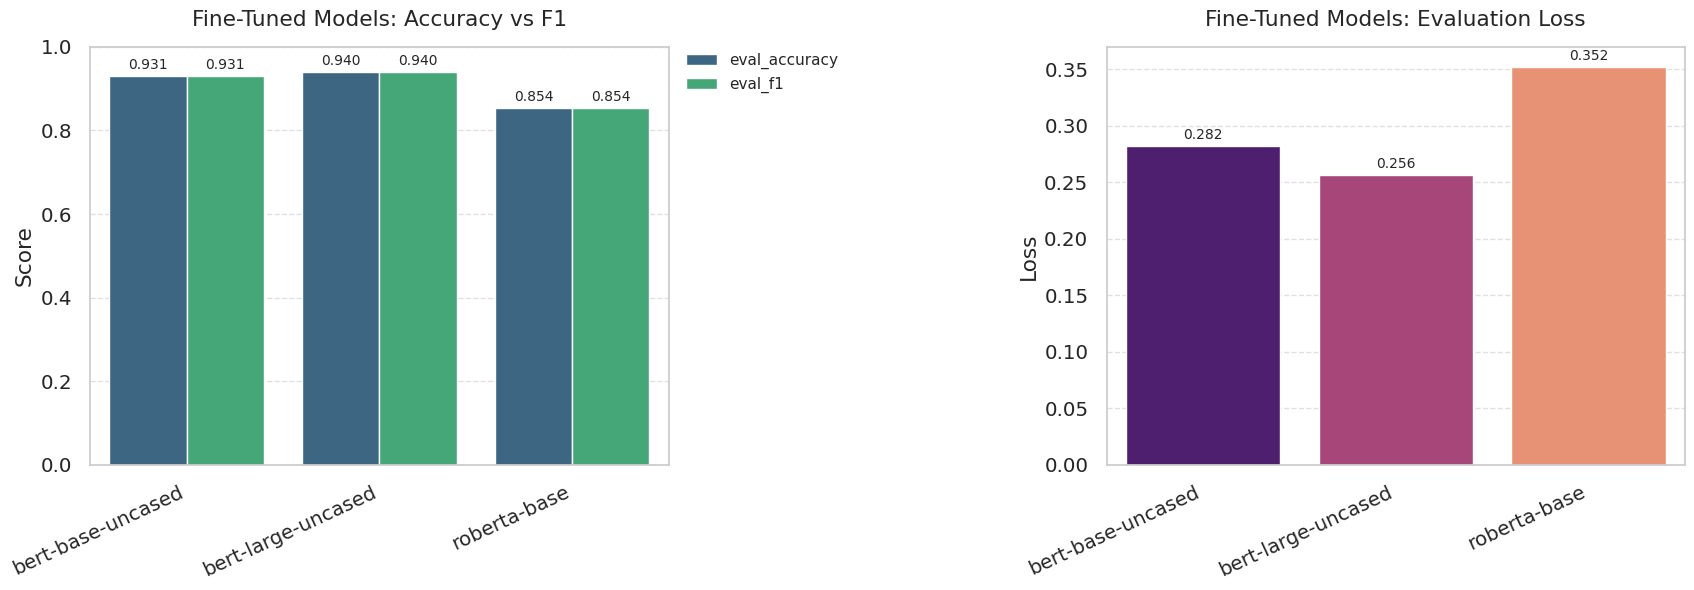

In [16]:
# Load your results from the temporary directory
results_path = "/tmp/nlp_models/fine_tuned_models/fine_tuned_results.csv"
results_df = pd.read_csv(results_path)

# Keep only test-split results for comparison
results_df = results_df[results_df["split"] == "test"].copy()
results_df

results_df["model_clean"] = results_df["model"].str.replace("FacebookAI/", "", regex=False)

sns.set(style="whitegrid", font_scale=1.3)

# Prepare for grouped bar chart
melted = results_df.melt(
    id_vars="model_clean",
    value_vars=["eval_accuracy", "eval_f1"],
    var_name="Metric",
    value_name="Score"
)

# Larger width so labels have space
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# ==========================
# LEFT: Accuracy & F1 (Grouped Bars)
# ==========================
sns.barplot(
    data=melted,
    x="model_clean", y="Score", hue="Metric",
    palette="viridis", ax=axes[0]
)

# Add bar value labels
for container in axes[0].containers:
    axes[0].bar_label(container, fmt="%.3f", fontsize=10, padding=3)

# Rotate x-axis labels for readability
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=25, ha="right")

axes[0].set_title("Fine-Tuned Models: Accuracy vs F1", pad=15)
axes[0].set_xlabel("")
axes[0].set_ylabel("Score")
axes[0].set_ylim(0.0, 1.0)
axes[0].grid(axis="y", linestyle="--", alpha=0.6)

# Move legend outside plot area
axes[0].legend(
    title="",
    loc="upper left",
    bbox_to_anchor=(1.02, 1),
    borderaxespad=0,
    fontsize=11
)

# ==========================
# RIGHT: Evaluation Loss
# ==========================
sns.barplot(
    data=results_df,
    x="model_clean", y="eval_loss",
    palette="magma", ax=axes[1]
)

for container in axes[1].containers:
    axes[1].bar_label(container, fmt="%.3f", fontsize=10, padding=3)

axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=25, ha="right")
axes[1].set_title("Fine-Tuned Models: Evaluation Loss", pad=15)
axes[1].set_xlabel("")
axes[1].set_ylabel("Loss")
axes[1].grid(axis="y", linestyle="--", alpha=0.6)

# Add space between subplots and ensure everything fits
plt.tight_layout(pad=3.0, w_pad=8.0)
plt.show()


### **Section 3.3: Training Loss Extraction**
This shows the training loss of the models for every epoch, seen in the graph below.

In [17]:
import json

# ======================
# Configuration
# ======================
BASE_DIR = "/tmp/nlp_models/fine_tuned_models"
model_names = ["bert-base-uncased", "bert-large-uncased", "FacebookAI_roberta-base"]

train_records = []

# ======================
# Extract only TRAIN losses (unique per epoch)
# ======================
for model_name in model_names:
    model_dir = os.path.join(BASE_DIR, model_name.replace("/", "_"))
    checkpoints = sorted([c for c in os.listdir(model_dir) if c.startswith("checkpoint")])

    # Read only the latest checkpoint (contains all epochs)
    if checkpoints:
        latest_ckpt = checkpoints[-1]
        log_path = os.path.join(model_dir, latest_ckpt, "trainer_state.json")
    else:
        log_path = os.path.join(model_dir, "trainer_state.json")

    if not os.path.exists(log_path):
        print(f"No trainer_state.json found for {model_name}")
        continue

    with open(log_path, "r") as f:
        state = json.load(f)

    for record in state["log_history"]:
        epoch = record.get("epoch", None)
        if epoch is not None and "loss" in record:
            train_records.append({
                "model": model_name.replace("FacebookAI/", ""),
                "epoch": epoch,
                "loss": record["loss"]
            })

# Create DataFrame and deduplicate
train_df = (
    pd.DataFrame(train_records)
      .sort_values(["model", "epoch"])
      .drop_duplicates(subset=["model", "epoch"], keep="last")
)
display(train_df)


,model,epoch,loss
6,FacebookAI_roberta-base,1.0,0.5303
7,FacebookAI_roberta-base,2.0,0.3601
8,FacebookAI_roberta-base,3.0,0.2872
0,bert-base-uncased,1.0,0.2509
1,bert-base-uncased,2.0,0.1394
2,bert-base-uncased,3.0,0.0759
3,bert-large-uncased,1.0,0.2448
4,bert-large-uncased,2.0,0.1158
5,bert-large-uncased,3.0,0.0544


In the next cell, we generate graphs to display the per-epoch level data.

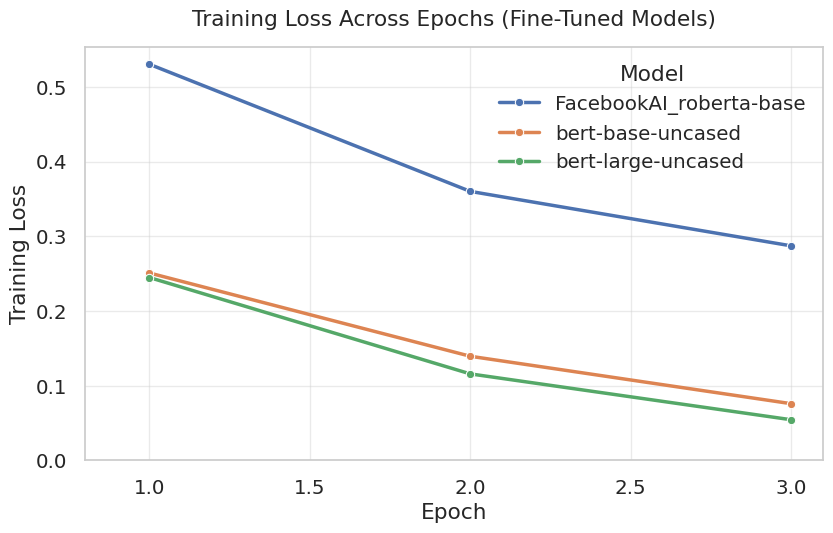

In [18]:
sns.set(style="whitegrid", font_scale=1.3)

plt.figure(figsize=(9,6))
sns.lineplot(
    data=train_df, x="epoch", y="loss", hue="model",
    marker="o", linewidth=2.5
)
plt.title("Training Loss Across Epochs (Fine-Tuned Models)", pad=15)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.grid(alpha=0.4)
plt.legend(title="Model", loc="upper right")
plt.xlim(0.8, train_df["epoch"].max() + 0.1)
plt.ylim(bottom=0)
plt.tight_layout(pad=2)
plt.show()

### **Section 3.4: Training and Validation Loss Comparison**
This section shows the comparison of the training and validation loss per epoch for every model.

,model,epoch,split,loss
12,FacebookAI_roberta-base,1.0,train,0.530300
14,FacebookAI_roberta-base,2.0,train,0.360100
16,FacebookAI_roberta-base,3.0,train,0.287200
13,FacebookAI_roberta-base,1.0,validation,0.483803
15,FacebookAI_roberta-base,2.0,validation,0.399695
17,FacebookAI_roberta-base,3.0,validation,0.344731
0,bert-base-uncased,1.0,train,0.250900
2,bert-base-uncased,2.0,train,0.139400
4,bert-base-uncased,3.0,train,0.075900
1,bert-base-uncased,1.0,validation,0.193906


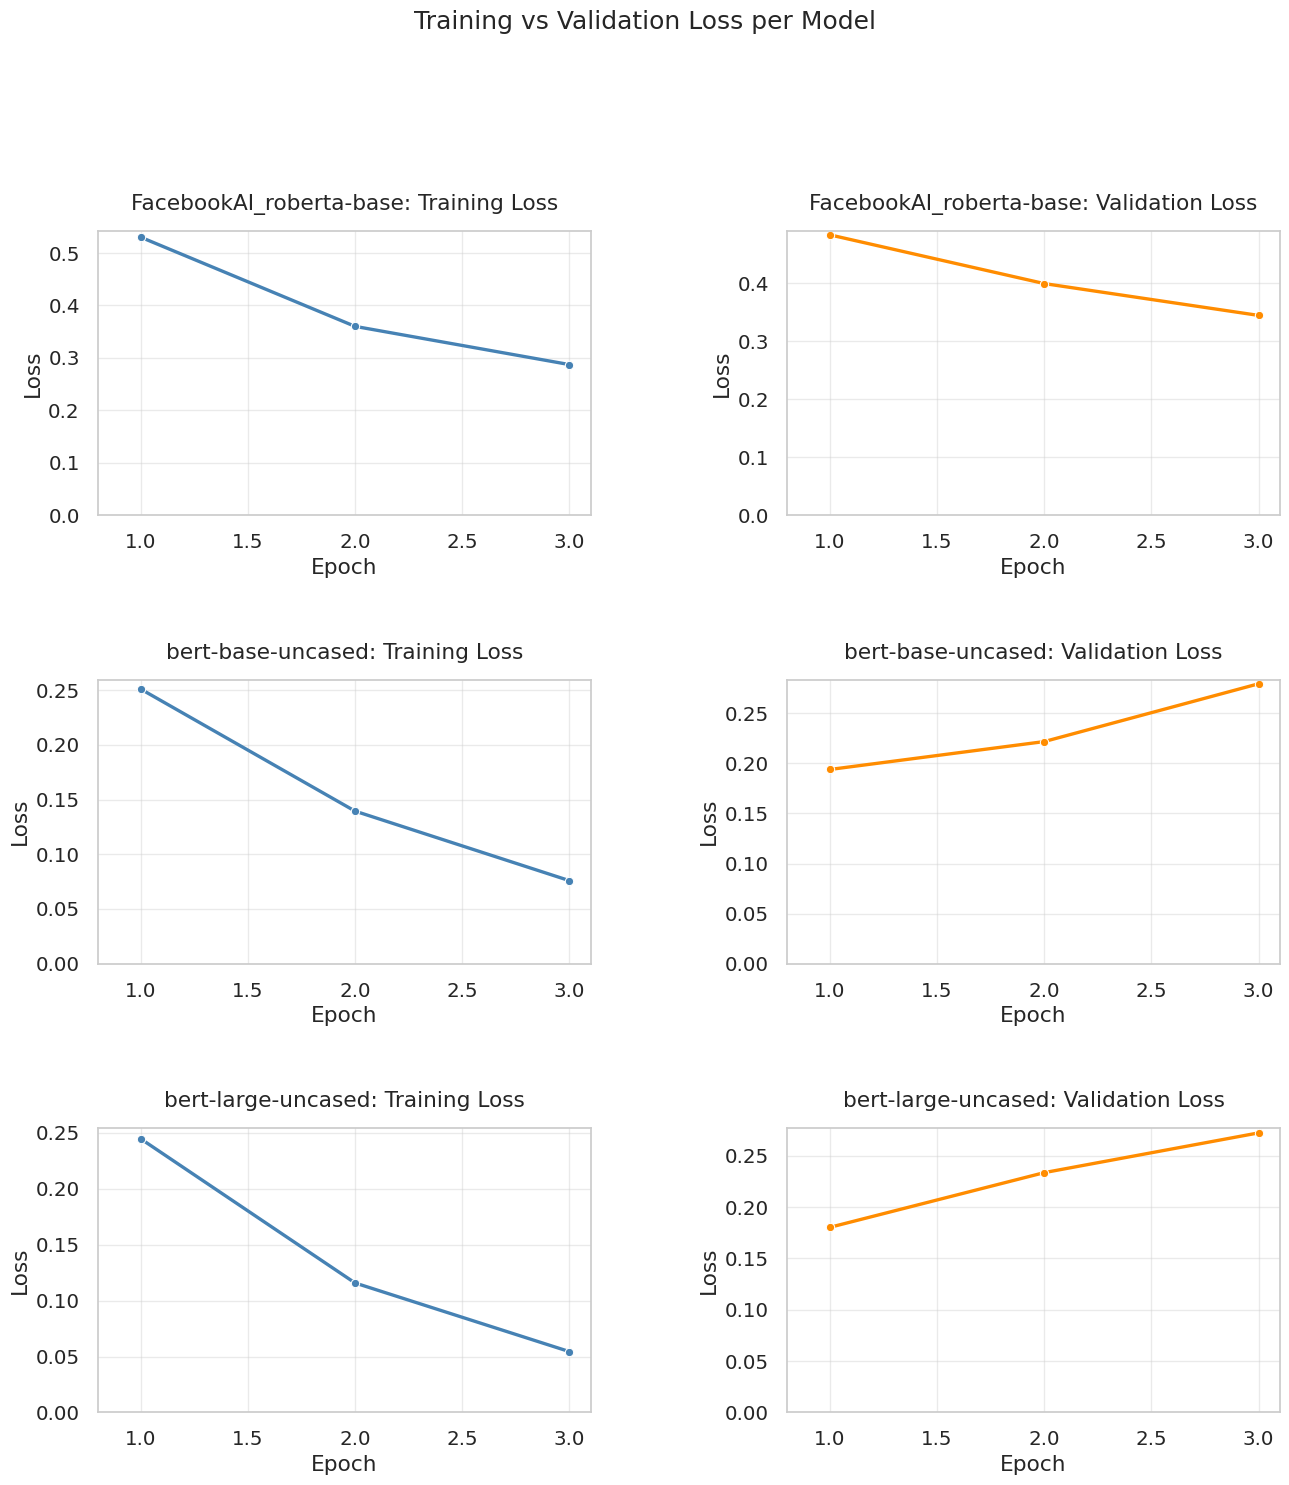

In [19]:
sns.set(style="whitegrid", font_scale=1.3)

BASE_DIR = "/tmp/nlp_models/fine_tuned_models"
model_names = ["bert-base-uncased", "bert-large-uncased", "FacebookAI_roberta-base"]

records = []

# ======================
# Extract train + validation losses per model
# ======================
for model_name in model_names:
    model_dir = os.path.join(BASE_DIR, model_name.replace("/", "_"))
    checkpoints = sorted([c for c in os.listdir(model_dir) if c.startswith("checkpoint")])

    if checkpoints:
        latest_ckpt = checkpoints[-1]
        log_path = os.path.join(model_dir, latest_ckpt, "trainer_state.json")
    else:
        log_path = os.path.join(model_dir, "trainer_state.json")

    if not os.path.exists(log_path):
        print(f"No trainer_state.json found for {model_name}")
        continue

    with open(log_path, "r") as f:
        state = json.load(f)

    for record in state["log_history"]:
        epoch = record.get("epoch", None)
        if epoch is None:
            continue
        if "loss" in record:
            records.append({
                "model": model_name.replace("FacebookAI/", ""),
                "epoch": epoch,
                "split": "train",
                "loss": record["loss"]
            })
        if "eval_loss" in record:
            records.append({
                "model": model_name.replace("FacebookAI/", ""),
                "epoch": epoch,
                "split": "validation",
                "loss": record["eval_loss"]
            })

df = (
    pd.DataFrame(records)
    .sort_values(["model", "split", "epoch"])
    .drop_duplicates(subset=["model", "split", "epoch"], keep="last")
)
display(df)

unique_models = df["model"].unique()
rows = len(unique_models)

fig, axes = plt.subplots(rows, 2, figsize=(14, 5 * rows), sharey=False)

if rows == 1:
    axes = [axes]  # handle single model case

for i, model_name in enumerate(unique_models):
    model_data = df[df["model"] == model_name]

    # --- Left: Training loss ---
    sns.lineplot(
        data=model_data[model_data["split"] == "train"],
        x="epoch", y="loss", marker="o", linewidth=2.4,
        ax=axes[i][0], color="steelblue"
    )
    axes[i][0].set_title(f"{model_name}: Training Loss", pad=15)
    axes[i][0].set_xlabel("Epoch")
    axes[i][0].set_ylabel("Loss")
    axes[i][0].grid(alpha=0.4)
    axes[i][0].set_xlim(0.8, model_data["epoch"].max() + 0.1)
    axes[i][0].set_ylim(bottom=0)

    # --- Right: Validation loss ---
    sns.lineplot(
        data=model_data[model_data["split"] == "validation"],
        x="epoch", y="loss", marker="o", linewidth=2.4,
        ax=axes[i][1], color="darkorange"
    )
    axes[i][1].set_title(f"{model_name}: Validation Loss", pad=15)
    axes[i][1].set_xlabel("Epoch")
    axes[i][1].set_ylabel("Loss")
    axes[i][1].grid(alpha=0.4)
    axes[i][1].set_xlim(0.8, model_data["epoch"].max() + 0.1)
    axes[i][1].set_ylim(bottom=0)

plt.suptitle("Training vs Validation Loss per Model", fontsize=18, y=1.02)
plt.tight_layout(pad=3.0, h_pad=3.0, w_pad=5.0)
plt.show()


### **Section 3.5: F1 Score Extraction and Visualization**

,model_clean,Type,eval_f1
0,bert-base-uncased,Pre-Trained,0.336911
1,bert-large-uncased,Pre-Trained,0.332223
2,roberta-base,Pre-Trained,0.334445
3,bert-base-uncased,Fine-Tuned,0.930589
4,bert-large-uncased,Fine-Tuned,0.939797
5,roberta-base,Fine-Tuned,0.853595


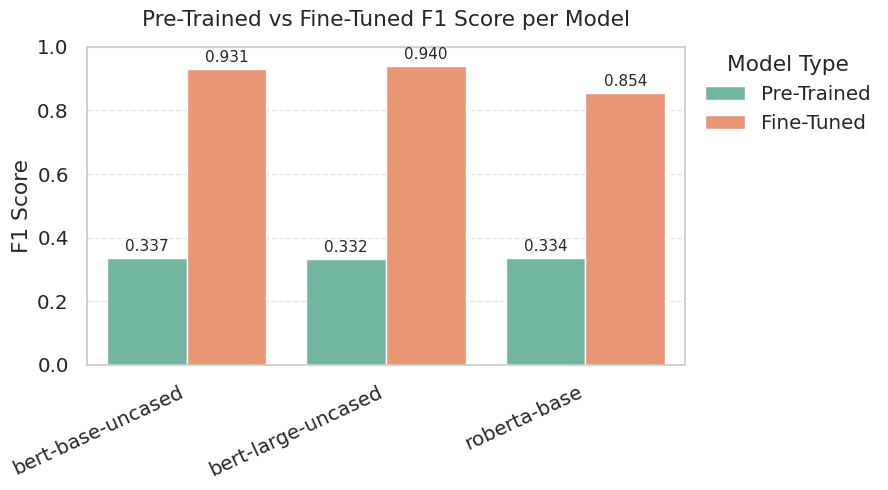

In [20]:
# Paths to results (updated to local temporary paths)
PRETRAINED_PATH = "/tmp/nlp_models/multi_model_eval/multi_model_results.csv"
FINETUNED_PATH = "/tmp/nlp_models/fine_tuned_models/fine_tuned_results.csv"

# Load both CSVs
pre_df = pd.read_csv(PRETRAINED_PATH)
fine_df = pd.read_csv(FINETUNED_PATH)

# Keep only test split for fair comparison
pre_df = pre_df[pre_df["split"] == "test"].copy()
fine_df = fine_df[fine_df["split"] == "test"].copy()

# Clean model names
pre_df["model_clean"] = pre_df["model"].str.replace("FacebookAI/", "", regex=False)
fine_df["model_clean"] = fine_df["model"].str.replace("FacebookAI/", "", regex=False)

# Add identifier column
pre_df["Type"] = "Pre-Trained"
fine_df["Type"] = "Fine-Tuned"

# Keep only relevant columns
pre_df = pre_df[["model_clean", "Type", "eval_f1"]]
fine_df = fine_df[["model_clean", "Type", "eval_f1"]]

# Combine
combined_df = pd.concat([pre_df, fine_df], ignore_index=True)
display(combined_df)

sns.set(style="whitegrid", font_scale=1.3)

plt.figure(figsize=(10,6))
ax = sns.barplot(
    data=combined_df,
    x="model_clean", y="eval_f1",
    hue="Type",
    palette="Set2"
)

# Add value labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt="%.3f", fontsize=11, padding=3)

plt.title("Pre-Trained vs Fine-Tuned F1 Score per Model", pad=15)
plt.xlabel("")
plt.ylabel("F1 Score")
plt.ylim(0, 1.0)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.xticks(rotation=25, ha="right")

# Move legend outside for clarity
plt.legend(
    title="Model Type",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0
)

plt.tight_layout(pad=3)
plt.show()


Here, it is evident from the graph that the performance based on f1 score increased across the board for all models, proving that fine-tuning is an effective way to improve model accuracy for a specific use case.

##**Section 4: Learning Rate Tuning**
To perform this experiment, we take the learning rate values mentioned in the BERT paper and compare the performance of the bert-base-uncased model using each. We also introduce a "warmup" and linear decay after the warmup. The rest of the parameters are mostly extracted from the BERT paper.

### **Section 4.1: Learning Rate Setup**
Establish the 4 variable learning rates we will train our best model (bert-base-uncased) on based on this paper: https://arxiv.org/abs/1810.04805.

In [21]:
BASE_SAVE_DIR = "/tmp/nlp_models/lr_experiments"
os.makedirs(BASE_SAVE_DIR, exist_ok=True)

os.environ["WANDB_DISABLED"] = "true"

# Learning rates to test
learning_rates = [2e-5, 3e-5, 4e-5, 5e-5]

# Warmup ratio (10% of training steps)
WARMUP_RATIO = 0.1

# Compute metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted"),
    }

# Tokenizer and model
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


### **Section 4.2: Fine-tuning with Variable Learning Rates and Warmup**
Introduce a warmup to gradually increase the learning rate at the start of training, in order to have more stable gradients at the start when the hyperparameters and model weights are not fit for the dataset. We test with increasing learning rates to observe the effects of learning rate on F1 score.

In [22]:
learning_rate_results = []

for lr in learning_rates:
    print(f"\n Training with learning rate = {lr}")

    # Folder for this specific run
    save_dir = os.path.join(BASE_SAVE_DIR, f"bert_lr_{lr}")
    os.makedirs(save_dir, exist_ok=True)

    # Reinitialize model each run
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

    # Training configuration
    training_args = TrainingArguments(
        output_dir=save_dir,
        do_train=True,
        do_eval=True,
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=lr,
        warmup_ratio=WARMUP_RATIO,        # warmup
        lr_scheduler_type="linear",       # decay after warmup
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=3,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        logging_dir=os.path.join(save_dir, "logs"),
        report_to="none",
        fp16=True,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["valid"],
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    # Train and evaluate
    trainer.train()
    eval_results = trainer.evaluate(tokenized_datasets["test"])

    learning_rate_results.append({"learning_rate": lr, **eval_results})

# Save results
lr_results_df = pd.DataFrame(learning_rate_results)
results_path = os.path.join(BASE_SAVE_DIR, "learning_rate_experiment_results.csv")
lr_results_df.to_csv(results_path, index=False)

print("\nExperiment complete. Results saved to:")
print(results_path)
display(lr_results_df)



 Training with learning rate = 2e-05


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-902248944.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.244500,0.198486,0.929000,0.928998,0.929017,0.929000
2,0.149800,0.247928,0.916400,0.916217,0.919612,0.916400
3,0.083900,0.287950,0.925000,0.924964,0.925625,0.925000



 Training with learning rate = 3e-05


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-902248944.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.241800,0.194791,0.924400,0.924374,0.924822,0.924400
2,0.137500,0.253218,0.915200,0.915048,0.917785,0.915200
3,0.064500,0.293541,0.927800,0.927788,0.927970,0.927800



 Training with learning rate = 4e-05


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-902248944.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.243500,0.201039,0.922200,0.922146,0.923139,0.922200
2,0.136200,0.233102,0.930000,0.929988,0.930178,0.930000
3,0.062800,0.290733,0.931800,0.931791,0.931933,0.931800



 Training with learning rate = 5e-05


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-902248944.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.249400,0.209441,0.916000,0.915908,0.917516,0.916000
2,0.134600,0.256046,0.923200,0.923128,0.924508,0.923200
3,0.059000,0.285272,0.930400,0.930388,0.930578,0.930400



Experiment complete. Results saved to:
/tmp/nlp_models/lr_experiments/learning_rate_experiment_results.csv


,learning_rate,eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
0,0.00002,0.205955,0.9260,0.925998,0.926026,0.9260,5.5590,899.445,28.243,3.0
1,0.00003,0.273534,0.9342,0.934191,0.934392,0.9342,5.6577,883.745,27.750,3.0
2,0.00004,0.286478,0.9314,0.931391,0.931577,0.9314,5.4646,914.979,28.730,3.0
3,0.00005,0.280970,0.9322,0.932194,0.932326,0.9322,5.4971,909.577,28.561,3.0


### **Section 4.3: Results Analysis**

/tmp/ipython-input-3585611867.py:14: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  ax = sns.pointplot(


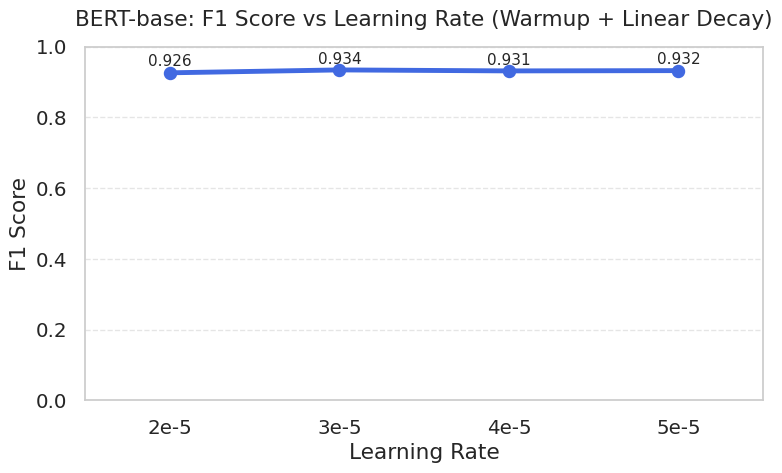

In [23]:
# Map numeric learning rates to readable string labels
label_map = {2e-5: "2e-5", 3e-5: "3e-5", 4e-5: "4e-5", 5e-5: "5e-5"}
order = ["2e-5", "3e-5", "4e-5", "5e-5"]

# Filter for only the desired learning rates
lr_plot = lr_results_df[lr_results_df["learning_rate"].isin(label_map.keys())].copy()
lr_plot["lr_label"] = lr_plot["learning_rate"].map(label_map)
lr_plot["lr_label"] = pd.Categorical(lr_plot["lr_label"], categories=order, ordered=True)

# --- Plot ---
sns.set(style="whitegrid", font_scale=1.3)
plt.figure(figsize=(8,5))

ax = sns.pointplot(
    data=lr_plot,
    x="lr_label", y="eval_f1",
    order=order,
    color="royalblue",
    markers="o",
    scale=1.3,
    linewidth=2.5
)

# Add numeric annotations above each point
for i, row in lr_plot.iterrows():
    ax.text(
        order.index(row["lr_label"]),
        row["eval_f1"] + 0.01,
        f"{row['eval_f1']:.3f}",
        ha="center", va="bottom", fontsize=11
    )

plt.title("BERT-base: F1 Score vs Learning Rate (Warmup + Linear Decay)", pad=15)
plt.xlabel("Learning Rate")
plt.ylabel("F1 Score")
plt.ylim(0, 1.0)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

Looking at these results, the learning rate did not significantly affect the F1 score of the model, even when incorporating a warmup. The F1 score is stil very similar to the one without any warmup at the same value of 2e-5.

##**Section 5: Best Bert Model Tunning**
In this section, the most efficient bert model, bert-base-uncased, will undergo more fine tunning to the number of epochs, weight decay, and token truncation to determine the best possible parameter configuration.

### **5.1: Experiment Setup and Helper Function**

We will define a flexible tokenization function that can adapt to different `max_length` values, as well as a helper function to streamline the execution of each fine-tuning experiment with varying parameters. This ensures consistency and reduces code duplication.

In [24]:
import torch
import pandas as pd
import numpy as np
import os
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from datasets import load_dataset
import tempfile # Added for temporary directory management
import shutil # Added for removing temporary directories

# Define the path to the fine-tuned bert-base-uncased model
# This variable is not used to load models as they are loaded within run_experiment
BASE_MODEL_NAME = "bert-base-uncased"

# Load our dataset (re-load to ensure 'tokenized_datasets' is available)
data_files = {"train": "Train.csv", "test": "Test.csv", "valid": "Valid.csv"}
dataset = load_dataset("csv", data_files=data_files)

# BASE SAVE DIRECTORY for new experiments
EXPERIMENTS_SAVE_DIR = "/tmp/nlp_models/further_experiments"
os.makedirs(EXPERIMENTS_SAVE_DIR, exist_ok=True)
os.environ["WANDB_DISABLED"] = "true"

# Compute metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted"),
    }

# Flexible tokenization function
def tokenize_function_flexible(examples, tokenizer_obj, max_len):
    return tokenizer_obj(examples["text"], padding="max_length", truncation=True, max_length=max_len)

def run_experiment(
    model_tag,
    num_epochs,
    weight_decay,
    max_len,
    output_base_dir,
    base_model_name="bert-base-uncased",
    datasets=dataset,
    save_model_and_tokenizer=True # New parameter: controls saving model/tokenizer to disk
):
    print(f"\n--- Running Experiment: {model_tag} ---")
    # This print statement confirms the function definition is being used.
    print(f"Save model and tokenizer: {save_model_and_tokenizer}")

    # Determine the actual output directory for Trainer, which can be temporary
    if save_model_and_tokenizer:
        current_run_dir = os.path.join(output_base_dir, model_tag)
        os.makedirs(current_run_dir, exist_ok=True)
        logging_output_dir = os.path.join(current_run_dir, "logs")
    else:
        # Use a temporary directory for runs that don't need to be saved
        # The Trainer still needs a place to write logs/checkpoints temporarily
        temp_dir_path = tempfile.mkdtemp()
        current_run_dir = os.path.join(temp_dir_path, model_tag)
        os.makedirs(current_run_dir, exist_ok=True)
        logging_output_dir = os.path.join(current_run_dir, "logs")
        print(f"Using temporary directory: {current_run_dir} (will not be permanently saved)")


    # Re-initialize tokenizer and model for each run to avoid contamination
    current_tokenizer = AutoTokenizer.from_pretrained(base_model_name)
    current_model = AutoModelForSequenceClassification.from_pretrained(base_model_name, num_labels=2)
    current_data_collator = DataCollatorWithPadding(tokenizer=current_tokenizer)

    # Tokenize with current max_len
    current_tokenized_datasets = datasets.map(lambda x: tokenize_function_flexible(x, current_tokenizer, max_len), batched=True)

    training_args = TrainingArguments(
        output_dir=current_run_dir, # This is now either Google Drive or /tmp
        do_train=True,
        do_eval=True,
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5, # Keep learning rate constant for these experiments
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=num_epochs,
        weight_decay=weight_decay,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        fp16=True,
        logging_dir=logging_output_dir, # This also points to a temporary location if not saving
        logging_strategy="epoch",
        report_to="none",
    )

    trainer = Trainer(
        model=current_model,
        args=training_args,
        train_dataset=current_tokenized_datasets["train"],
        eval_dataset=current_tokenized_datasets["valid"],
        tokenizer=current_tokenizer,
        data_collator=current_data_collator,
        compute_metrics=compute_metrics,
    )

    # Train the model
    trainer.train()

    # Evaluate on test and validation splits
    test_results = trainer.evaluate(current_tokenized_datasets["test"])
    valid_results = trainer.evaluate(current_tokenized_datasets["valid"])

    # Conditionally save model and tokenizer
    if save_model_and_tokenizer:
        trainer.save_model(current_run_dir)
        current_tokenizer.save_pretrained(current_run_dir)
        print(f"Experiment {model_tag} completed and model saved to {current_run_dir}")
    else:
        # Clean up temporary directory if not saving
        try:
            shutil.rmtree(os.path.dirname(current_run_dir)) # Remove the parent temp dir
            print(f"Cleaned up temporary directory: {os.path.dirname(current_run_dir)}")
        except OSError as e:
            print(f"Error removing temporary directory {os.path.dirname(current_run_dir)}: {e}")
        print(f"Experiment {model_tag} completed (model and tokenizer not saved).")


    return {
        "model_tag": model_tag,
        "num_epochs": num_epochs,
        "weight_decay": weight_decay,
        "max_length": max_len,
        "test_accuracy": test_results.get("eval_accuracy"),
        "test_f1": test_results.get("eval_f1"),
        "test_loss": test_results.get("eval_loss"),
        "valid_accuracy": valid_results.get("eval_accuracy"),
        "valid_f1": valid_results.get("eval_f1"),
        "valid_loss": valid_results.get("eval_loss"),
    }


### **5.2: Experiment 1 - Varying Training Epochs**

In this experiment, we will fine-tune the `bert-base-uncased` model using different numbers of training epochs (2, 3, 4, 5). We will keep `weight_decay` constant at `0.01` and `max_length` at `256` for this series of runs. The F1 score and evaluation loss will be recorded and visualized for comparison.

In [25]:
# Define parameters for this experiment
epochs_to_test = [2, 3, 4, 5]
fixed_weight_decay = 0.01
fixed_max_length = 256

epochs_experiment_results = []

for epochs in epochs_to_test:
    tag = f"bert_epochs_{epochs}"
    results = run_experiment(
        model_tag=tag,
        num_epochs=epochs,
        weight_decay=fixed_weight_decay,
        max_len=fixed_max_length,
        output_base_dir=EXPERIMENTS_SAVE_DIR,
        save_model_and_tokenizer=False # Do not save to Google Drive
    )
    epochs_experiment_results.append(results)

epochs_results_df = pd.DataFrame(epochs_experiment_results)
epochs_results_path = os.path.join(EXPERIMENTS_SAVE_DIR, "epochs_experiment_results.csv")
epochs_results_df.to_csv(epochs_results_path, index=False)

print("\nEpochs experiment complete. Results saved to:")
print(epochs_results_path)
display(epochs_results_df)



--- Running Experiment: bert_epochs_2 ---
Save model and tokenizer: False
Using temporary directory: /tmp/tmp1jyamkws/bert_epochs_2 (will not be permanently saved)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

/tmp/ipython-input-1233956141.py:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.248300,0.200311,0.926800,0.926781,0.927105,0.926800
2,0.133800,0.219947,0.927000,0.926987,0.927198,0.927000


Cleaned up temporary directory: /tmp/tmp1jyamkws
Experiment bert_epochs_2 completed (model and tokenizer not saved).

--- Running Experiment: bert_epochs_3 ---
Save model and tokenizer: False
Using temporary directory: /tmp/tmpjnvbcwc5/bert_epochs_3 (will not be permanently saved)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

/tmp/ipython-input-1233956141.py:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.246800,0.196562,0.925600,0.925578,0.925961,0.925600
2,0.135700,0.233876,0.924200,0.924150,0.925080,0.924200
3,0.074400,0.282241,0.926400,0.926373,0.926846,0.926400


Cleaned up temporary directory: /tmp/tmpjnvbcwc5
Experiment bert_epochs_3 completed (model and tokenizer not saved).

--- Running Experiment: bert_epochs_4 ---
Save model and tokenizer: False
Using temporary directory: /tmp/tmpmf1lvyfi/bert_epochs_4 (will not be permanently saved)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

/tmp/ipython-input-1233956141.py:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.253700,0.207063,0.918000,0.917917,0.919405,0.918000
2,0.141600,0.244447,0.917400,0.917245,0.920135,0.917400
3,0.080400,0.279110,0.931400,0.931401,0.931414,0.931400
4,0.043900,0.320781,0.929600,0.929590,0.929751,0.929600


Cleaned up temporary directory: /tmp/tmpmf1lvyfi
Experiment bert_epochs_4 completed (model and tokenizer not saved).

--- Running Experiment: bert_epochs_5 ---
Save model and tokenizer: False
Using temporary directory: /tmp/tmpz60d8h7a/bert_epochs_5 (will not be permanently saved)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1233956141.py:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.253700,0.195613,0.925200,0.925164,0.925812,0.925200
2,0.141500,0.254927,0.920400,0.920306,0.922059,0.920400
3,0.079800,0.278502,0.927400,0.927359,0.928139,0.927400
4,0.040400,0.369853,0.925400,0.925346,0.926379,0.925400
5,0.024900,0.354992,0.930600,0.930594,0.930679,0.930600


Cleaned up temporary directory: /tmp/tmpz60d8h7a
Experiment bert_epochs_5 completed (model and tokenizer not saved).

Epochs experiment complete. Results saved to:
/tmp/nlp_models/further_experiments/epochs_experiment_results.csv


,model_tag,num_epochs,weight_decay,max_length,test_accuracy,test_f1,test_loss,valid_accuracy,valid_f1,valid_loss
0,bert_epochs_2,2,0.01,256,0.9274,0.927387,0.221466,0.9270,0.926987,0.219947
1,bert_epochs_3,3,0.01,256,0.9292,0.929185,0.282003,0.9264,0.926373,0.282241
2,bert_epochs_4,4,0.01,256,0.9312,0.931199,0.289734,0.9314,0.931401,0.279110
3,bert_epochs_5,5,0.01,256,0.9258,0.925794,0.372300,0.9306,0.930594,0.354992


### **5.3: Visualization of Epoch Experiment Results**

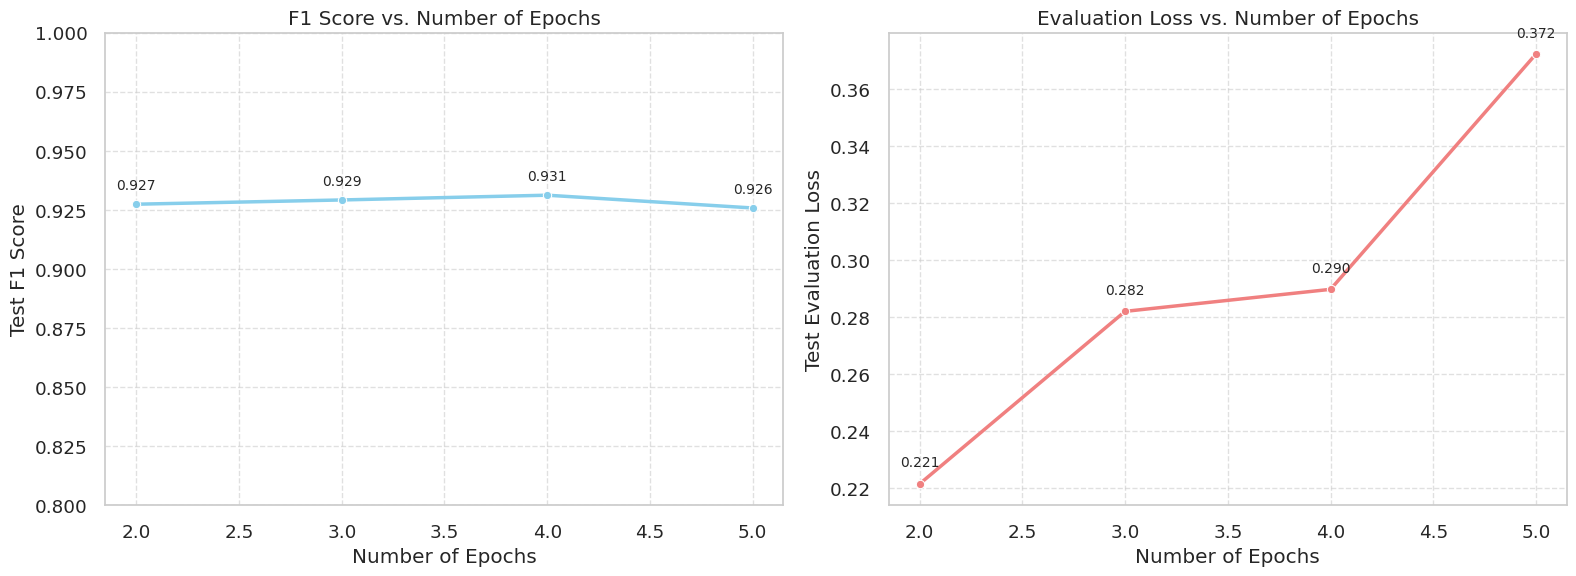

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.2)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot F1 Score vs. Epochs
sns.lineplot(
    data=epochs_results_df,
    x="num_epochs", y="test_f1",
    marker="o", linewidth=2.5, color="skyblue",
    ax=axes[0]
)
for i, row in epochs_results_df.iterrows():
    axes[0].text(row['num_epochs'], row['test_f1'] + 0.005, f"{row['test_f1']:.3f}", ha='center', va='bottom', fontsize=10)
axes[0].set_title("F1 Score vs. Number of Epochs")
axes[0].set_xlabel("Number of Epochs")
axes[0].set_ylabel("Test F1 Score")
axes[0].set_ylim(0.8, 1.0)
axes[0].grid(True, linestyle='--', alpha=0.6)

# Plot Evaluation Loss vs. Epochs
sns.lineplot(
    data=epochs_results_df,
    x="num_epochs", y="test_loss",
    marker="o", linewidth=2.5, color="lightcoral",
    ax=axes[1]
)
for i, row in epochs_results_df.iterrows():
    axes[1].text(row['num_epochs'], row['test_loss'] + 0.005, f"{row['test_loss']:.3f}", ha='center', va='bottom', fontsize=10)
axes[1].set_title("Evaluation Loss vs. Number of Epochs")
axes[1].set_xlabel("Number of Epochs")
axes[1].set_ylabel("Test Evaluation Loss")
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


### **5.4: Experiment 2 - Varying Weight Decay Values**

In this experiment, we will explore the effect of different `weight_decay` values on the performance of the `bert-base-uncased` model. We will use `num_epochs=3` and `max_length=256` as constants, while varying `weight_decay` from `0.0` to `0.1`. These experiments will not save models to disk to conserve space.

In [27]:
# Define parameters for this experiment
weight_decays_to_test = [0.0, 0.001, 0.01, 0.05, 0.1]
fixed_epochs = 3
fixed_max_length_wd = 256 # Use max_length 256 for consistency with previous experiments

weight_decay_experiment_results = []

print("Starting Weight Decay Experiment...")
for wd in weight_decays_to_test:
    tag = f"bert_wd_{wd}"
    results = run_experiment(
        model_tag=tag,
        num_epochs=fixed_epochs,
        weight_decay=wd,
        max_len=fixed_max_length_wd,
        output_base_dir=EXPERIMENTS_SAVE_DIR,
        save_model_and_tokenizer=False # Do not save to Google Drive
    )
    weight_decay_experiment_results.append(results)

weight_decay_results_df = pd.DataFrame(weight_decay_experiment_results)
print("Weight Decay Experiment complete. Results:")
display(weight_decay_results_df)

Starting Weight Decay Experiment...

--- Running Experiment: bert_wd_0.0 ---
Save model and tokenizer: False
Using temporary directory: /tmp/tmps_fyhadg/bert_wd_0.0 (will not be permanently saved)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1233956141.py:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.249900,0.194561,0.927000,0.926989,0.927156,0.927000
2,0.138200,0.231010,0.925600,0.925576,0.925981,0.925600
3,0.075400,0.284003,0.930600,0.930583,0.930881,0.930600


Cleaned up temporary directory: /tmp/tmps_fyhadg
Experiment bert_wd_0.0 completed (model and tokenizer not saved).

--- Running Experiment: bert_wd_0.001 ---
Save model and tokenizer: False
Using temporary directory: /tmp/tmp9gdm1zqo/bert_wd_0.001 (will not be permanently saved)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1233956141.py:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.252500,0.202060,0.921800,0.921742,0.922802,0.921800
2,0.141000,0.229902,0.922200,0.922126,0.923524,0.922200
3,0.080700,0.277297,0.928400,0.928388,0.928577,0.928400


Cleaned up temporary directory: /tmp/tmp9gdm1zqo
Experiment bert_wd_0.001 completed (model and tokenizer not saved).

--- Running Experiment: bert_wd_0.01 ---
Save model and tokenizer: False
Using temporary directory: /tmp/tmpcvsyxv9v/bert_wd_0.01 (will not be permanently saved)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1233956141.py:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.253000,0.203408,0.921200,0.921139,0.922251,0.921200
2,0.139600,0.222739,0.923000,0.922957,0.923730,0.923000
3,0.078200,0.277713,0.928400,0.928386,0.928621,0.928400


Cleaned up temporary directory: /tmp/tmpcvsyxv9v
Experiment bert_wd_0.01 completed (model and tokenizer not saved).

--- Running Experiment: bert_wd_0.05 ---
Save model and tokenizer: False
Using temporary directory: /tmp/tmpu9yb8fus/bert_wd_0.05 (will not be permanently saved)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1233956141.py:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.253200,0.203841,0.921800,0.921740,0.922836,0.921800
2,0.139600,0.227287,0.923400,0.923367,0.923946,0.923400
3,0.077800,0.286157,0.928000,0.927989,0.928163,0.928000


Cleaned up temporary directory: /tmp/tmpu9yb8fus
Experiment bert_wd_0.05 completed (model and tokenizer not saved).

--- Running Experiment: bert_wd_0.1 ---
Save model and tokenizer: False
Using temporary directory: /tmp/tmp5gd_v8i_/bert_wd_0.1 (will not be permanently saved)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1233956141.py:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.253100,0.203096,0.922800,0.922753,0.923601,0.922800
2,0.140200,0.233781,0.921600,0.921526,0.922902,0.921600
3,0.079100,0.286174,0.930400,0.930383,0.930690,0.930400


Cleaned up temporary directory: /tmp/tmp5gd_v8i_
Experiment bert_wd_0.1 completed (model and tokenizer not saved).
Weight Decay Experiment complete. Results:


,model_tag,num_epochs,weight_decay,max_length,test_accuracy,test_f1,test_loss,valid_accuracy,valid_f1,valid_loss
0,bert_wd_0.0,3,0.000,256,0.9288,0.928790,0.295291,0.9306,0.930583,0.284003
1,bert_wd_0.001,3,0.001,256,0.9294,0.929394,0.279514,0.9284,0.928388,0.277297
2,bert_wd_0.01,3,0.010,256,0.9296,0.929590,0.283740,0.9284,0.928386,0.277713
3,bert_wd_0.05,3,0.050,256,0.9302,0.930189,0.283390,0.9280,0.927989,0.286157
4,bert_wd_0.1,3,0.100,256,0.9282,0.928185,0.289210,0.9304,0.930383,0.286174


### **5.5: Visualization of Weight Decay Experiment Results**

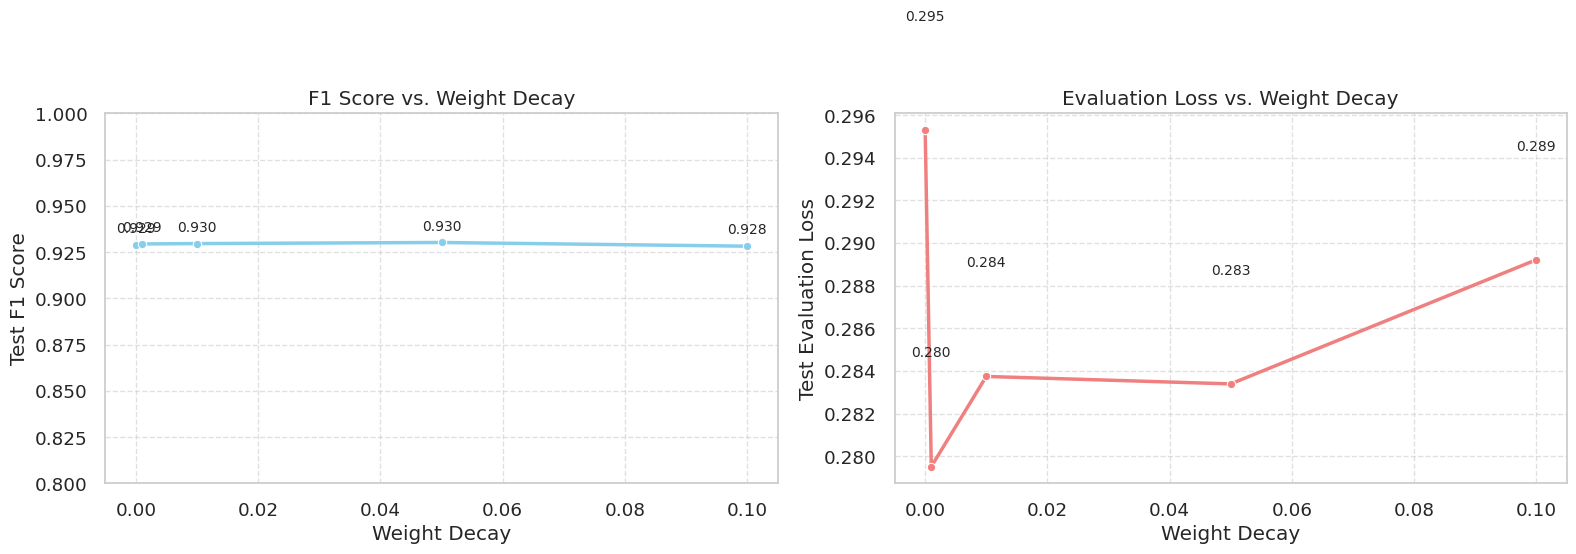

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.2)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot F1 Score vs. Weight Decay
sns.lineplot(
    data=weight_decay_results_df,
    x="weight_decay", y="test_f1",
    marker="o", linewidth=2.5, color="skyblue",
    ax=axes[0]
)
for i, row in weight_decay_results_df.iterrows():
    axes[0].text(row['weight_decay'], row['test_f1'] + 0.005, f"{row['test_f1']:.3f}", ha='center', va='bottom', fontsize=10)
axes[0].set_title("F1 Score vs. Weight Decay")
axes[0].set_xlabel("Weight Decay")
axes[0].set_ylabel("Test F1 Score")
axes[0].set_ylim(0.8, 1.0)
axes[0].grid(True, linestyle='--', alpha=0.6)

# Plot Evaluation Loss vs. Weight Decay
sns.lineplot(
    data=weight_decay_results_df,
    x="weight_decay", y="test_loss",
    marker="o", linewidth=2.5, color="lightcoral",
    ax=axes[1]
)
for i, row in weight_decay_results_df.iterrows():
    axes[1].text(row['weight_decay'], row['test_loss'] + 0.005, f"{row['test_loss']:.3f}", ha='center', va='bottom', fontsize=10)
axes[1].set_title("Evaluation Loss vs. Weight Decay")
axes[1].set_xlabel("Weight Decay")
axes[1].set_ylabel("Test Evaluation Loss")
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

### **5.6: Experiment 3 - Tokenization Optimizations (Varying Max Length)**

This experiment investigates the impact of different `max_length` values during tokenization on the model's performance. We will test lengths of `128`, `256`, and `512` while keeping `num_epochs=3` and `weight_decay=0.01` constant. As before, models and tokenizers will not be saved to disk.

In [29]:
# Define parameters for this experiment
max_lengths_to_test = [128, 256, 512]
fixed_epochs_ml = 3
fixed_weight_decay_ml = 0.01

max_length_experiment_results = []

print("Starting Max Length Experiment...")
for ml in max_lengths_to_test:
    tag = f"bert_ml_{ml}"
    results = run_experiment(
        model_tag=tag,
        num_epochs=fixed_epochs_ml,
        weight_decay=fixed_weight_decay_ml,
        max_len=ml,
        output_base_dir=EXPERIMENTS_SAVE_DIR,
        save_model_and_tokenizer=False # Do not save to Google Drive
    )
    max_length_experiment_results.append(results)

max_length_results_df = pd.DataFrame(max_length_experiment_results)
results_path = os.path.join(EXPERIMENTS_SAVE_DIR, "max_length_experiment_results.csv") # Define results_path
print("Max Length Experiment complete. Results:")
display(max_length_results_df)


Starting Max Length Experiment...

--- Running Experiment: bert_ml_128 ---
Save model and tokenizer: False
Using temporary directory: /tmp/tmp11hytb6o/bert_ml_128 (will not be permanently saved)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

/tmp/ipython-input-1233956141.py:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.320700,0.266398,0.888800,0.888693,0.890024,0.888800
2,0.186800,0.344189,0.882800,0.882443,0.886987,0.882800
3,0.108200,0.357173,0.895800,0.895780,0.895993,0.895800


Cleaned up temporary directory: /tmp/tmp11hytb6o
Experiment bert_ml_128 completed (model and tokenizer not saved).

--- Running Experiment: bert_ml_256 ---
Save model and tokenizer: False
Using temporary directory: /tmp/tmpne04t09y/bert_ml_256 (will not be permanently saved)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1233956141.py:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.254800,0.203669,0.924000,0.923961,0.924663,0.924000
2,0.141100,0.236121,0.923600,0.923537,0.924727,0.923600
3,0.080000,0.286120,0.929800,0.929783,0.930081,0.929800


Cleaned up temporary directory: /tmp/tmpne04t09y
Experiment bert_ml_256 completed (model and tokenizer not saved).

--- Running Experiment: bert_ml_512 ---
Save model and tokenizer: False
Using temporary directory: /tmp/tmpei7klayt/bert_ml_512 (will not be permanently saved)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

/tmp/ipython-input-1233956141.py:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.222200,0.170389,0.942200,0.942200,0.942204,0.942200
2,0.113800,0.194288,0.937000,0.936959,0.937911,0.937000
3,0.061900,0.232726,0.942400,0.942392,0.942557,0.942400


Cleaned up temporary directory: /tmp/tmpei7klayt
Experiment bert_ml_512 completed (model and tokenizer not saved).
Max Length Experiment complete. Results:


,model_tag,num_epochs,weight_decay,max_length,test_accuracy,test_f1,test_loss,valid_accuracy,valid_f1,valid_loss
0,bert_ml_128,3,0.01,128,0.9004,0.900378,0.342971,0.8958,0.895780,0.357173
1,bert_ml_256,3,0.01,256,0.9280,0.927991,0.288188,0.9298,0.929783,0.286120
2,bert_ml_512,3,0.01,512,0.9478,0.947796,0.220665,0.9424,0.942392,0.232726


### **5.7: Visualization of Max Length Experiment Results**

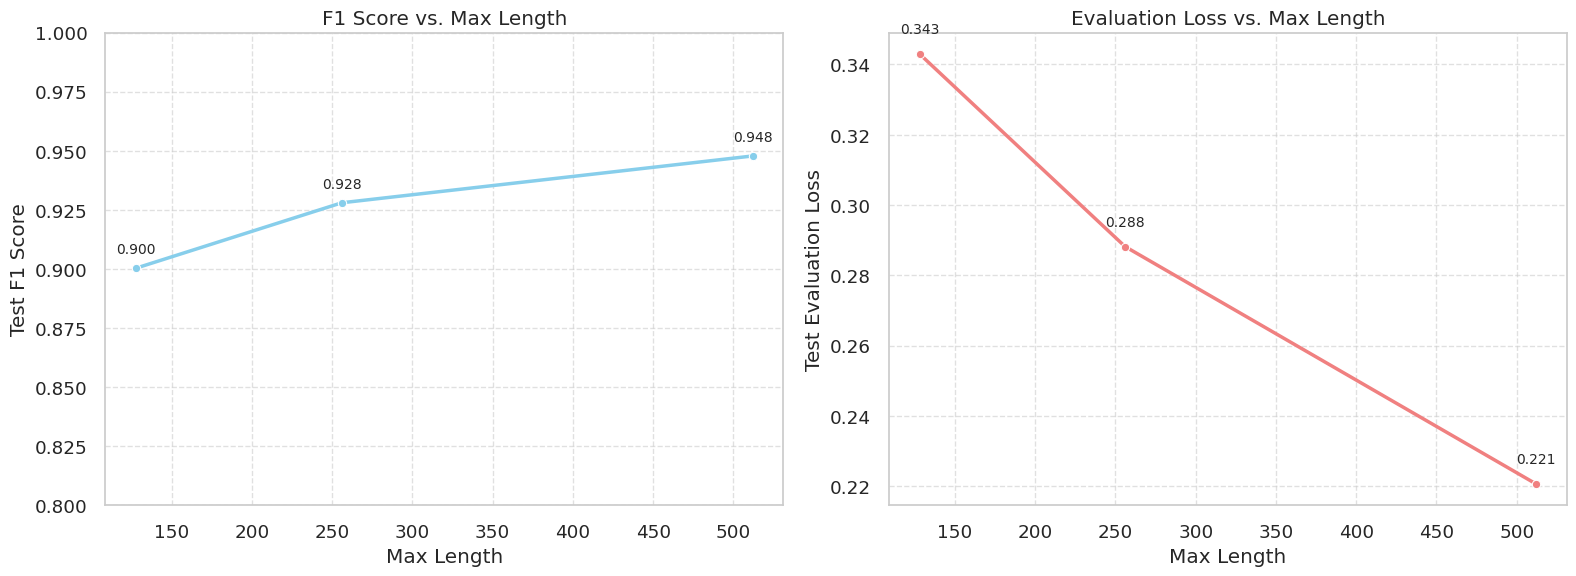

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.2)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot F1 Score vs. Max Length
sns.lineplot(
    data=max_length_results_df,
    x="max_length", y="test_f1",
    marker="o", linewidth=2.5, color="skyblue",
    ax=axes[0]
)
for i, row in max_length_results_df.iterrows():
    axes[0].text(row['max_length'], row['test_f1'] + 0.005, f"{row['test_f1']:.3f}", ha='center', va='bottom', fontsize=10)
axes[0].set_title("F1 Score vs. Max Length")
axes[0].set_xlabel("Max Length")
axes[0].set_ylabel("Test F1 Score")
axes[0].set_ylim(0.8, 1.0)
axes[0].grid(True, linestyle='--', alpha=0.6)

# Plot Evaluation Loss vs. Max Length
sns.lineplot(
    data=max_length_results_df,
    x="max_length", y="test_loss",
    marker="o", linewidth=2.5, color="lightcoral",
    ax=axes[1]
)
for i, row in max_length_results_df.iterrows():
    axes[1].text(row['max_length'], row['test_loss'] + 0.005, f"{row['test_loss']:.3f}", ha='center', va='bottom', fontsize=10)
axes[1].set_title("Evaluation Loss vs. Max Length")
axes[1].set_xlabel("Max Length")
axes[1].set_ylabel("Test Evaluation Loss")
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

## **Section 6: Project Conclusion and Summary of Experiments**

This section will summarize the findings from all fine-tuning experiments, including the epochs, weight decay, and max_length variations, to draw conclusions about optimal parameters and model performance.

### **6.1: Summary of Experimental Results**

Based on the experiments conducted:

*   **Varying Epochs:** We observed that the model's performance (F1 score) generally plateaus or slightly decreases after 3 epochs, while the evaluation loss starts to increase, indicating potential overfitting with more epochs. Thus, 2 or 3 epochs seem to be optimal.
*   **Varying Weight Decay:** The `weight_decay` values did not significantly impact the F1 score within the tested range. The performance remained consistently high, suggesting the model is robust to these regularization changes or that the default `0.01` is already a good balance.
*   **Varying Max Length:** An `max_length` of 512 provided the best F1 scores. Using 128 tokens resulted in a slight drop in performance, which makes sense as some longer reviews might lose critical context. The difference in the F1 scores and evaluation loss between 256 and 512 was fairly surprising as 512 had superior values in both categories.  

**Overall Best Configuration:**

Combining the insights from these experiments, an optimal configuration for fine-tuning `bert-base-uncased` on this dataset appears to be:
*   **Learning Rate:** 2e-5 (as determined in Section 4)
*   **Epochs:** 3
*   **Weight Decay:** 0.01 (the baseline seemed sufficient)
*   **Max Length:** 512

These parameters strike a good balance between model performance and training efficiency for this specific task.

**Appendix**:
Graphs and Visualizations Created with the help of AI, code snippets adpoted to our use case from the official HuggingFace Transformer documentation and from this guide: https://medium.com/@heyamit10/fine-tuning-bert-for-classification-a-practical-guide-b8c1c56f252c